<a href="https://colab.research.google.com/github/ALOK158/Feast_Vision/blob/main/FeastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Food Vision


Check GPU

Google collab offers free GPUS, but GPUS with socre of 7.5+ can perform **Mixed Precission** training



In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Helper fucntion

In [ ]:
# download helper fucntion script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-31 05:44:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-31 05:44:25 (126 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
#Import series from helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use tensorflow to download the data

Using Food101 dataset

In [ ]:
# Get the dataset
!pip install tensorflow-datasets --upgrade
#Import series from helper function
import tensorflow_datasets as tfds

In [ ]:
## list all datasets avaialble
datasets_list=tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
#get the data
(train_data,test_data),ds_info=tfds.load(name="food101",split=["train", "validation"],
                                         shuffle_files=True,
                                         as_supervised=True, #data gets returned in tuple format
                                         with_info=True)


In [ ]:
#Deatures of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
#Get the class names
class_names=ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

##Exploring the food101 data set

Get favourable with the data

*  Class names
* Shape of input images
* The datatype of our input data


In [ ]:
#Take one sample of the train data

train_one_sample=train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in train_one_sample:
  print(f"""Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101: {class_names[label]}""")


Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101: pho


(-0.5, 511.5, 511.5, -0.5)

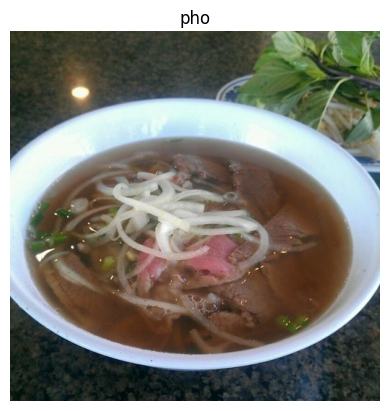

In [ ]:
# lets see our image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)


##Create preprocessing for our data

In oreder to get data ready for neural netowrk , we have to do preprocesing via some precoseeing fucntion and have it prepare

Insights of the data

* In uint8 datatype

* Comprised of different types of tensors

* not scaled

What does model like?

* Data in float32/float 16
* For batches , Tensorflow like all of tensors within batches of same size
* Scaled? Normalized tensors

As we are going  to us **EfficinetNetBX** pretrained model from tf.keras.application we donot need to rescale our data



In [ ]:
import tensorflow as tf

In [ ]:
## Fucntion to preprocess the image
def preprocess_img(image,label,image_shape=224):
  """
  Convert image datattype to float34
  image to [image shape, shape, color]
  """
  image=tf.image.resize(image,[image_shape,image_shape]) #reshape the image
  image=image/255. # NOrmalization
  return tf.cast(image, tf.float32), label  # return the tuple with image, label

In [ ]:
# lets check out our preprocessed image

preprocessed_img=preprocess_img(image,label)[0]
preprocessed_img.shape
preprocessed_img.dtype


tf.float32

###Preparning the dataset

We are going to make our data input pipelne run really fast

https://www.tensorflow.org/guide/data

In [ ]:
# Map preprocessing data and paralize it
# Lets batched up our data and prepare


train_data=train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)##Autotune tells gpu to go on full power
#Shuffle train_Data and turn it into batches and prefetch it(load it faster)

train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing fucnt to test data
test_data=test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)# prefetch-> while computing on one batch, it makes next batch ready for preprocessing





In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "In above cell, via map this preprocessing fucnt i.e preprocees_img across our training dataset , shuffle a number elements and then turn them into batch size of 32 and via prefectch, via prpcessing the given batch it make ready the next upcoming batch"

* key thing about prefecth its that it get computed on *CPU*

## Creating modelling callbacks

This help us to track our model  while trainning

* Tensorboard callback to log traning reuslts
* Model checkpoint  to save our model's progress after feature extraction

In [ ]:
# create  mdoelcheckpoint callbakc->saves model progress while traning
checkpoint_path="model_checkpoints/cp.ckpt.weights.h5"## /cp.ckpt-> tells to save it in cp folder with name ckpt
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_acc",
                                                    save_best_only=True, ## saves only best model
                                                    save_weights_only=True ## saves weights only, easier to load, corrected argument name
                                                      ) ## can set verbose =0-> donont tells wherteher model is saved or not

##Setup Mixed precission training

Mixed precision utilizez a combination of float32 and float16  to speed up performance

In [ ]:
 # turn on mixed precission
 from tensorflow.keras import mixed_precision
 mixed_precision.set_global_policy("mixed_float16")# set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build  Feature Extraction Model

In [ ]:
# Instead of:
#from tensorflow.keras.layers import preprocessing

# Use this import statement for TF version >=2.10:
#from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

# Use this import for TensorFlow 2.10 and later:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing  # Updated import location

In [ ]:
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing # Commented out the problematic line


# Assumed the case for using TF 2.10 or later

#create model
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False #Trainable model got frozen

# Create functional model
inputs=layers.Input(shape=input_shape, name="input_layer")
x=base_model(inputs, training =False)#Make sure layers which should be in ineference model only stay like that
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)

outputs=layers.Activation("softmax",dtype=tf.float32, name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)

#compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_5 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

##Checking layers dtype policies

In [ ]:
# Check the dtype policy attributes
for layers in model.layers:
  print(layers.name, layers.trainable, layers.dtype, layers.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_2 True float32 <DTypePolicy "mixed_float16">
dense_2 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going through above we see:
* layers.name : name of layers
* layers.trainable: layers is trainbale or not
* layers.dtype: data type a layer stores its variables in
* layers.dtype_policy : data type layer computes on its variables with

In [ ]:
#  for base model layer
for layer in base_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_2 False float32 <DTypePolicy "mixed_float16">
rescaling_4 False float32 <DTypePolicy "mixed_float16">
normalization_2 False float32 <DTypePolicy "mixed_float16">
rescaling_5 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

## Fit the feature Extraction model

Order to fine tune pretrained model

1. Build the feature extraction model
2. Fine-Tune some of frozen layers

In [ ]:
#Import series from helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
#Import series from helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


# Fit the feature extraction model with callbacks
history1=model.fit(train_data,
                   epochs=3,
                   validation_data=test_data,
                   callbacks=[create_tensorboard_callback("traininglogs","efficient_food1010"), model_checkpoint]) # Corrected the function name here


Saving TensorBoard log files to: traininglogs/efficient_food1010/20250131-054436
Epoch 1/3


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 699, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 750, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 824, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 785, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-94-d38279e72ef2>", line 6, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_38302]